In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import nltk
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [ ]:
import kagglehub
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Path to dataset files:", path)

100%|██████████| 25.7M/25.7M [00:02<00:00, 12.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1


In [ ]:
df = pd.read_csv(f"{path}/IMDB Dataset.csv")

print(df[:3])

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive


In [ ]:


nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

df["cleaned_review"] = df["review"].apply(clean_text)
print(df.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                              review sentiment  \
0  One of the other reviewers has mentioned that ...  positive   
1  A wonderful little production. <br /><br />The...  positive   
2  I thought this was a wonderful way to spend ti...  positive   
3  Basically there's a family where a little boy ...  negative   
4  Petter Mattei's "Love in the Time of Money" is...  positive   

                                      cleaned_review  
0  one reviewers mentioned watching oz episode ho...  
1  wonderful little production filming technique ...  
2  thought wonderful way spend time hot summer we...  
3  basically family little boy jake thinks zombie...  
4  petter mattei love time money visually stunnin...  


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["cleaned_review"], df["sentiment"], test_size=0.2, random_state=42)

In [ ]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
max_length = 200

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding="post", truncating="post")

In [ ]:
y_train = np.array(y_train.map({"positive": 1, "negative": 0}), dtype=np.int32)
y_test = np.array(y_test.map({"positive": 1, "negative": 0}), dtype=np.int32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - accuracy: 0.5050 - loss: 0.6924 - val_accuracy: 0.5377 - val_loss: 0.6725
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6664 - loss: 0.6087 - val_accuracy: 0.6233 - val_loss: 0.6616
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.6532 - loss: 0.6248 - val_accuracy: 0.7724 - val_loss: 0.5324
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.8617 - loss: 0.3419 - val_accuracy: 0.8805 - val_loss: 0.2945
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9323 - loss: 0.1817 - val_accuracy: 0.8848 - val_loss: 0.2940
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8869 - loss: 0.2879
Test Accuracy: 0.8848


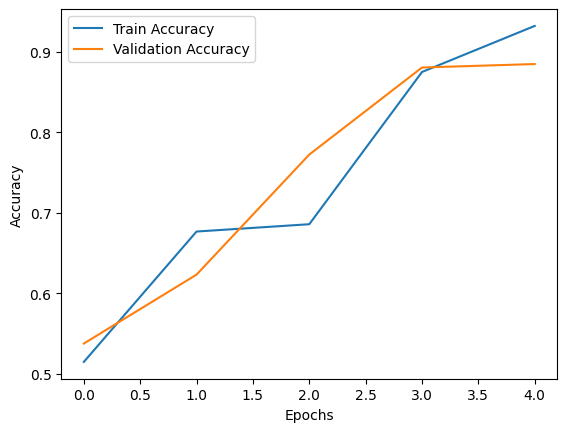

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test))

loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
def predict_sentiment(review):
    review = clean_text(review)
    sequence = tokenizer.texts_to_sequences([review])
    padded = pad_sequences(sequence, maxlen=max_length, padding="post")
    prediction = model.predict(padded)[0][0]
    return "Positive" if prediction > 0.5 else "Negative"

# Test predictions
print(predict_sentiment("This movie was fantastic! I loved it."))
print(predict_sentiment("Worst movie ever. Waste of time."))
print(predict_sentiment("I waste my time, great"))
print(predict_sentiment("Impressive"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Positive
